In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

In [7]:
df = pd.read_csv("london_merged.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 17414 rows and 10 columns


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [8]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [9]:
data = df.copy().dropna()

# function to turn the hour of the day in intervals
def tday(h):
    time_of_day = None
    if h < 7:
        time_of_day = 0
    elif h >= 7 and h < 13:
        time_of_day = 1
    elif h >= 13 and h < 19:
        time_of_day = 2
    elif h >= 19:
        time_of_day = 3
    return time_of_day

def weather_map(w_code):
    new_code = None
    if w_code == 1:
        new_code = 0
    elif w_code == 2:
        new_code = 1
    elif w_code == 3:
        new_code = 2
    elif w_code == 4:
        new_code = 3
    elif w_code == 7:
        new_code = 4
    elif w_code == 10:
        new_code = 5
    elif w_code == 26:
        new_code = 6
    return new_code


data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['hour'] = data['timestamp'].apply(lambda x: int(tday(x.hour)))
data = data.drop(columns='timestamp').dropna()
data['is_holiday'] = data['is_holiday'].apply(lambda x: bool(x))
data['is_weekend'] = data['is_weekend'].apply(lambda x: bool(x))
data['season'] = data['season'].apply(lambda x: int(x))
data['cnt'] = data['cnt'].apply(lambda x: int(x))
data['weather_code'] = data['weather_code'].apply(lambda x: weather_map(int(x)))

# Transformation in deciles
for col in ('t1', 't2', 'hum', 'wind_speed', 'cnt'):
    bins = pd.qcut(df[col], q=4, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)

In [10]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,0,0,0,3,0,2,False,True,3,0
1,0,0,0,3,0,0,False,True,3,0
2,0,0,0,3,0,0,False,True,3,0
3,0,0,0,3,0,0,False,True,3,0
4,0,0,0,3,0,0,False,True,3,0


In [11]:
for cl in data.columns:
    print(cl)
    print(data[cl].value_counts())

cnt
0    4357
1    4355
3    4354
2    4348
Name: cnt, dtype: int64
t1
1    4556
0    4395
3    4324
2    4139
Name: t1, dtype: int64
t2
0    4672
3    4324
1    4279
2    4139
Name: t2, dtype: int64
hum
2    4598
0    4458
1    4258
3    4100
Name: hum, dtype: int64
wind_speed
0    4819
3    4279
1    4182
2    4134
Name: wind_speed, dtype: int64
weather_code
0    6150
1    4034
2    3551
4    2141
3    1464
6      60
5      14
Name: weather_code, dtype: int64
is_holiday
False    17030
True       384
Name: is_holiday, dtype: int64
is_weekend
False    12444
True      4970
Name: is_weekend, dtype: int64
season
0    4394
1    4387
3    4330
2    4303
Name: season, dtype: int64
hour
0    5058
2    4371
1    4358
3    3627
Name: hour, dtype: int64


In [12]:
data.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour'],
      dtype='object')

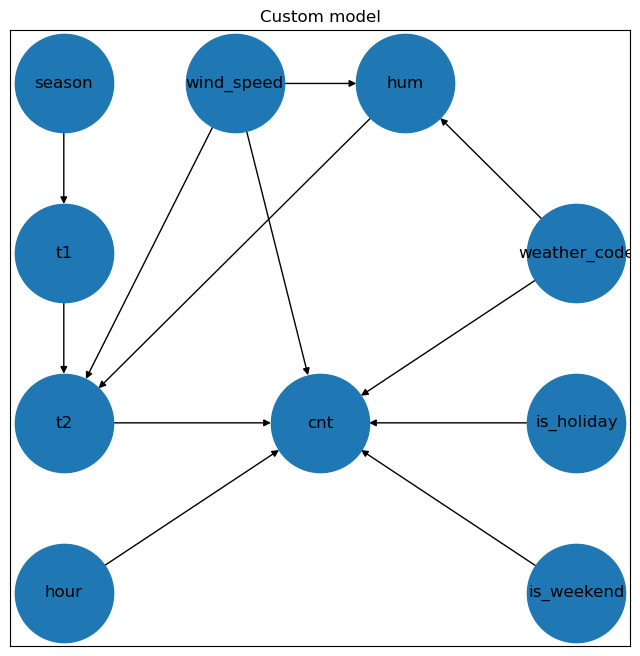

In [13]:
from pgmpy.models import BayesianNetwork

custom_model = BayesianNetwork([('t2', 'cnt'), ('wind_speed', 'cnt'),
                              ('weather_code', 'cnt'), ('is_holiday', 'cnt'), ('is_weekend', 'cnt'), ('hour','cnt'),
                              ('t1','t2'), ('hum', 't2'), ('wind_speed', 't2'),
                              ('season', 't1'), ('wind_speed', 'hum'), ('weather_code', 'hum')])

pos = {'cnt': [0, 1], 't1': [-1.5, 1.5], 't2': [-1.5, 1], 'hum': [0.5,  2],
       'wind_speed': [-0.5,  2], 'weather_code': [1.5, 1.5], 'is_holiday': [1.5,  1],
       'is_weekend': [1.5, 0.5], 'season': [-1.5, 2], 'hour': [-1.5, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
plt.show()

In [14]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(custom_model, data)
print("\n", pe.state_counts('t1'))


 season       0       1       2       3
t1                                    
0       1344.0     0.0   554.0  2497.0
1       1753.0   179.0  1358.0  1266.0
2        886.0  1092.0  1596.0   565.0
3        411.0  3116.0   795.0     2.0


In [15]:
from pgmpy.estimators import MaximumLikelihoodEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)
print(custom_model.get_cpds(node='t1'))

+--------+---------------------+----------------------+---------------------+------------------------+
| season | season(0)           | season(1)            | season(2)           | season(3)              |
+--------+---------------------+----------------------+---------------------+------------------------+
| t1(0)  | 0.3058716431497497  | 0.0                  | 0.12874738554496862 | 0.5766743648960739     |
+--------+---------------------+----------------------+---------------------+------------------------+
| t1(1)  | 0.3989531178880291  | 0.040802370640528836 | 0.3155937717871253  | 0.292378752886836      |
+--------+---------------------+----------------------+---------------------+------------------------+
| t1(2)  | 0.20163859808830223 | 0.24891725552769547  | 0.37090402045084825 | 0.13048498845265588    |
+--------+---------------------+----------------------+---------------------+------------------------+
| t1(3)  | 0.09353664087391898 | 0.7102803738317757   | 0.184754822217057

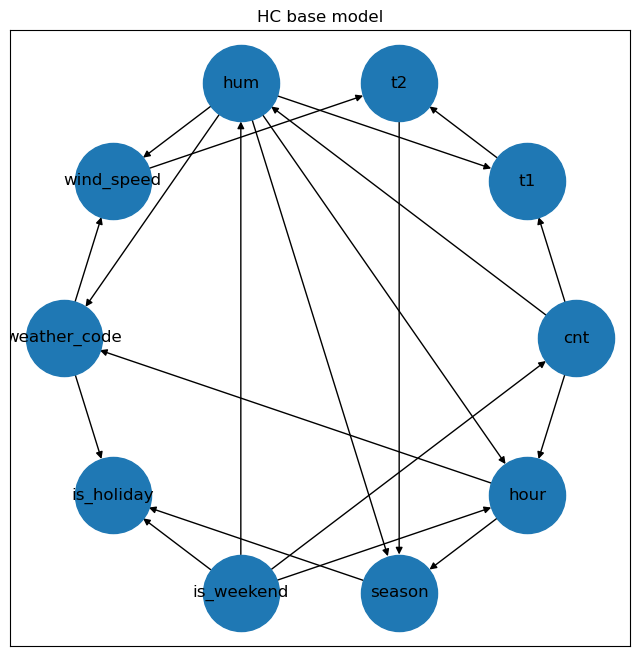

In [16]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
ax.set_title('HC base model')
hc_base_model = BayesianNetwork(hc_base_model.edges())

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images/hc_constr_model.png'

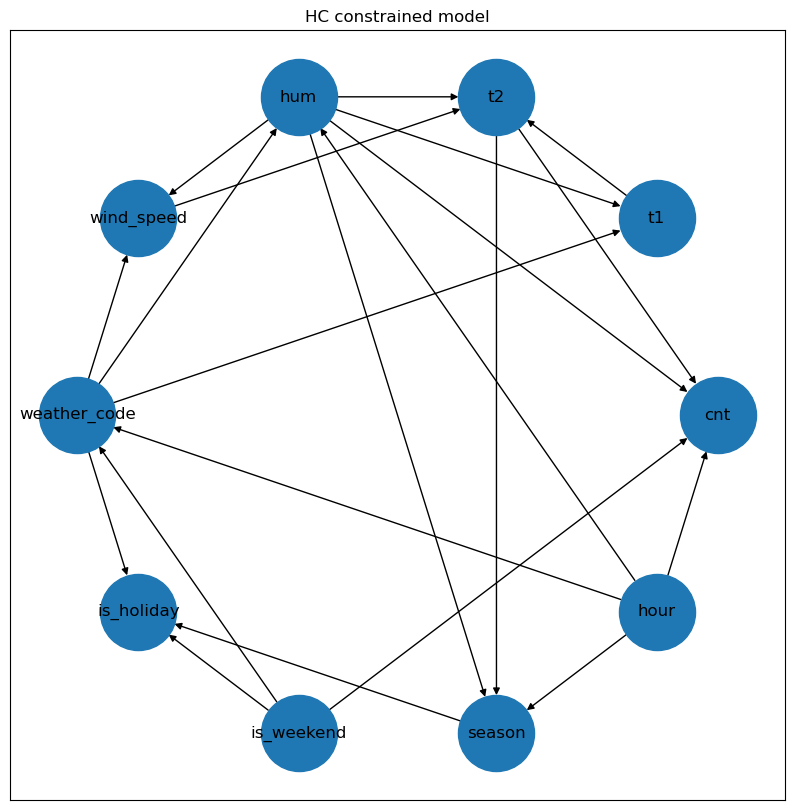

In [17]:
fixed_edges = [('hum', 't2'),('wind_speed', 't2'),('t1', 't2')]

black_list = [('cnt', c) for c in data.columns]

scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=3000)
ax.set_title('HC constrained model')
hc_constr_model = BayesianNetwork(hc_constr_model.edges())

plt.savefig('images/hc_constr_model.png')
plt.show()

In [18]:
hc_base_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_constr_model.fit(data, estimator=MaximumLikelihoodEstimator)

In [19]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore


bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)


print("Scores for the custom model")
print(bdeu.score(custom_model))
print(k2.score(custom_model))
print(bic.score(custom_model))
print("Scores for the model defined with hill climb with constraints")
print(bdeu.score(hc_constr_model))
print(k2.score(hc_constr_model))
print(bic.score(hc_constr_model))

Scores for the custom model
-173576.5396308202
-167955.34568052026
-192636.62416600855
Scores for the model defined with hill climb with constraints
-161991.98918027835
-161652.98010753305
-163759.30829413835
